##### Задание ПРО
Основные цели этого задания:
- научиться определять стационарность ряда статистическими методами
- познакомиться с библиотечными решениями для прогнозирования временных рядов и попрактиковаться в их использовании
*Задача:* спрогнозировать число пассажиров авиакомпании помесячно. В отличие от обычного задания, будем использовать готовые библиотечные решения.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import io
import zipfile

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import calendar

plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams['font.size'] = 10
plt.style.use('dark_background')

import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

In [2]:
param_plt = {
    'marker' : "o",
    'markersize' : 6,
    'linewidth' : 2}

#### 1. Загрузите данные из источника по ссылке, и подготовьте к прогнозированию.

In [3]:
try:
    archive = zipfile.ZipFile("archive.zip", "r")
    filename = "".join([i.filename for i in archive.filelist])
    txtdata = archive.read(filename)
    df = pd.read_csv(io.BytesIO(txtdata), sep=",", index_col=['Month'], parse_dates=True)
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
df.columns = df.columns.str.replace('#', '').str.lower()
df.columns

Index(['passengers'], dtype='object')

In [7]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


В датасете 2 столбца: object (в нем дата) и числовой.\
144 строки.

In [8]:
print("Пропущенных значений:", sum(df.isna().sum()))

Пропущенных значений: 0


In [9]:
df.index.is_monotonic_increasing

True

1.1 Оставьте только данные с 1952 по 1957 год включительно.

In [10]:
df_reduced = df['1952':'1957'].copy()

1.2. Визуализируйте временной ряд и продублируйте свои выводы из основного задания о том, имеются ли у ряда тренд, сезонность и является ли он стационарным.

Посмотрим на данные на график со скользящим средним для более ясной визуализации.

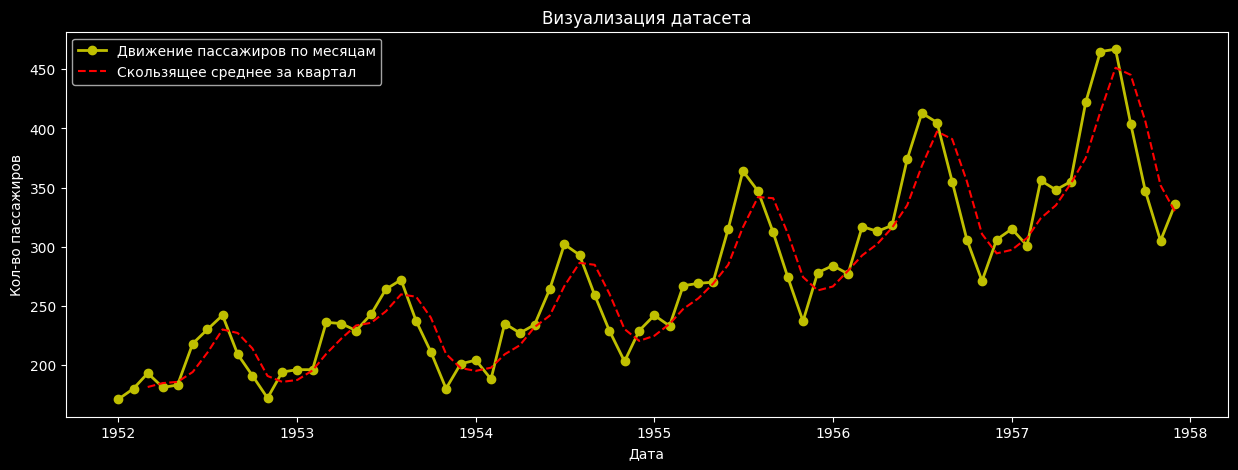

In [11]:
plt.title("Визуализация датасета")
plt.plot(df_reduced, color="y", label="Движение пассажиров по месяцам", **param_plt)
plt.plot(
    df_reduced.rolling(3).mean(),
    linestyle="--",
    label="Скользящее среднее за квартал",
    color="r",
)
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Кол-во пассажиров")
plt.show()

Уже по этому графику видно некий тренд и сезонность.

2.2. Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы:
- Есть ли тренд?
- Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?
- Является ли ряд стационарным и почему?

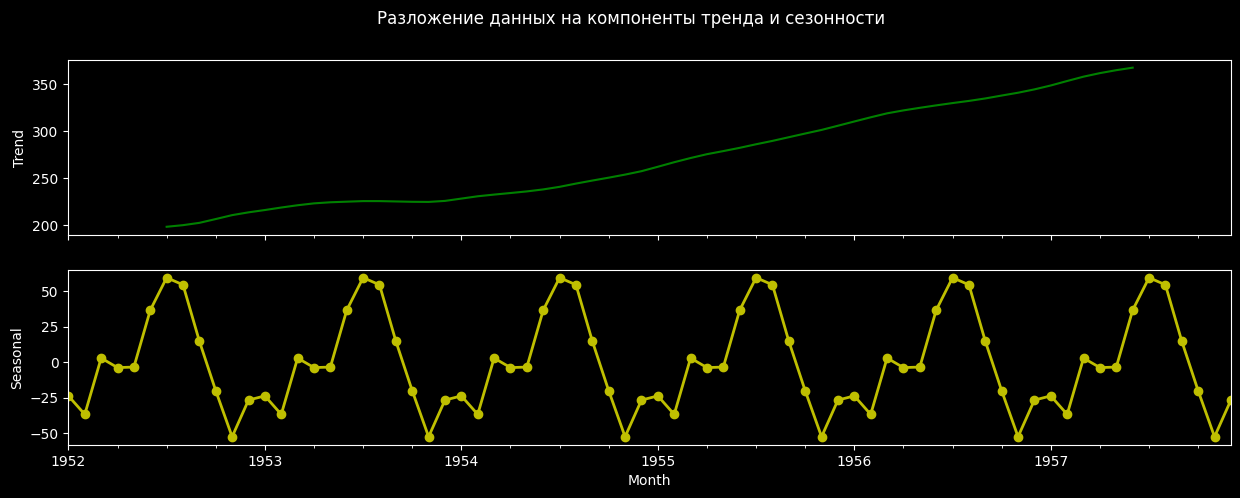

In [12]:
decompose = seasonal_decompose(df_reduced)

fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Разложение данных на компоненты тренда и сезонности")
decompose.trend.plot(ax=axes[0], legend=False, color="g")
axes[0].set_ylabel("Trend")
decompose.seasonal.plot(ax=axes[1], legend=False, color="y", **param_plt)
axes[1].set_ylabel("Seasonal")
plt.show()

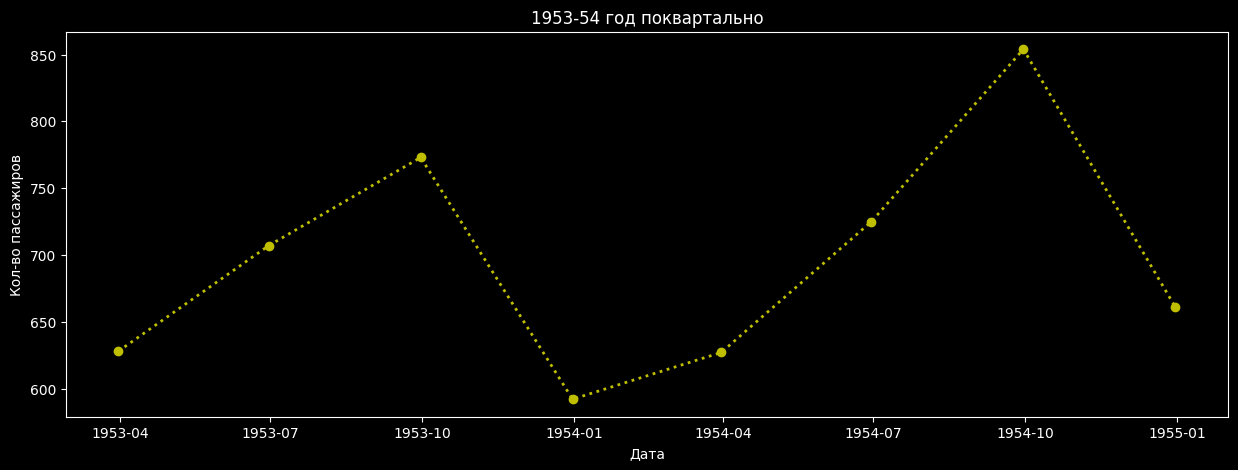

In [13]:
plt.title("1953-54 год поквартально")
plt.plot(
    df_reduced["1953":"1954"].resample("Q", label="right").sum(),
    color="y",
    linestyle="dotted",
    **param_plt
)
plt.xlabel("Дата")
plt.ylabel("Кол-во пассажиров")
plt.show()

Для надежности проведем тест Dickey-Fuller на стационарность.\
Н0: ряд нестационарный\
Н1: ряд стационарный

In [14]:
ad_fuller_result = adfuller(df_reduced.passengers)
p_value = ad_fuller_result[1]
print(f"ADF Statistic: {round(ad_fuller_result[0], 4)}, p-value: {round(p_value, 4)}")

alpha = 0.05

if p_value < alpha:
    print("Ряд стационарный (отклоняем H0)")
else:
    print("Ряд нестационарный (подтверждается H0)")

ADF Statistic: 0.8585, p-value: 0.9925
Ряд нестационарный (подтверждается H0)


Тренд временного ряда появляется с 1954 года, тренд идет на увеличение.\
Также видно сезонную повторяемость: рост с весны до конца сентября (сезон отпусков), и падение к концу года.
Ряд не является стационарным, так как у него есть тренд на увеличение и есть сезонность.\
Тест Dickey-Fuller показал  p-value = 99.25, что тоже подтверждает нестационарность.

1.3.Разделите данные на обучающую и валидационную части.

In [15]:
data_train, data_val = train_test_split(df_reduced, shuffle=False, test_size=0.2)

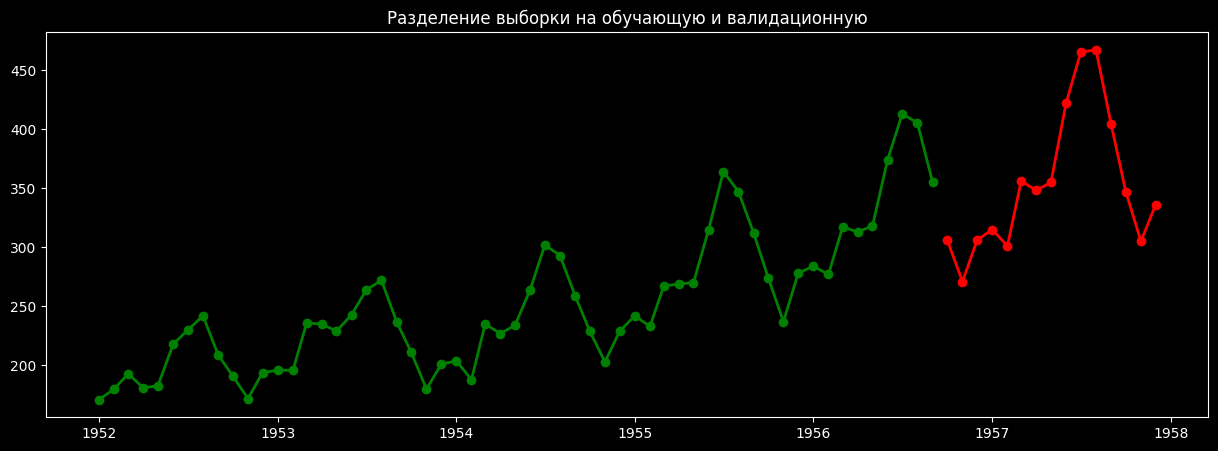

In [16]:
plt.title("Разделение выборки на обучающую и валидационную")
plt.plot(data_train, color="g", **param_plt)
plt.plot(data_val, color="r", **param_plt)
plt.show()

#### 2. Обучите AR-модель.

In [17]:
df_reduced.index.freq="MS"

In [18]:
def visualize_plot(title: str, predictions):
    plt.plot(predictions, label="predict", color="y", linewidth=2)
    plt.plot(data_val, label="val", color="r", linewidth=2)
    plt.plot(data_train, label="train", color="g", linewidth=2)
    plt.title(title)
    plt.ylabel("Пассажиры")
    plt.xlabel("Дата")

    plt.legend()
    plt.show()

2.1. Определите, какой гиперпараметр библиотечной модели отвечает за настройку AR-модели.

Параметр, отвечающий за авторегресию, параметр p - "period".

2.2. Переберите несколько вариантов значений гиперпараметров и выберите лучший по значению метрики MAE на валидационной выборке.

In [19]:
# начало и конец тестовых данных
start = len(data_train)
end = len(data_train) + len(data_val) - 1

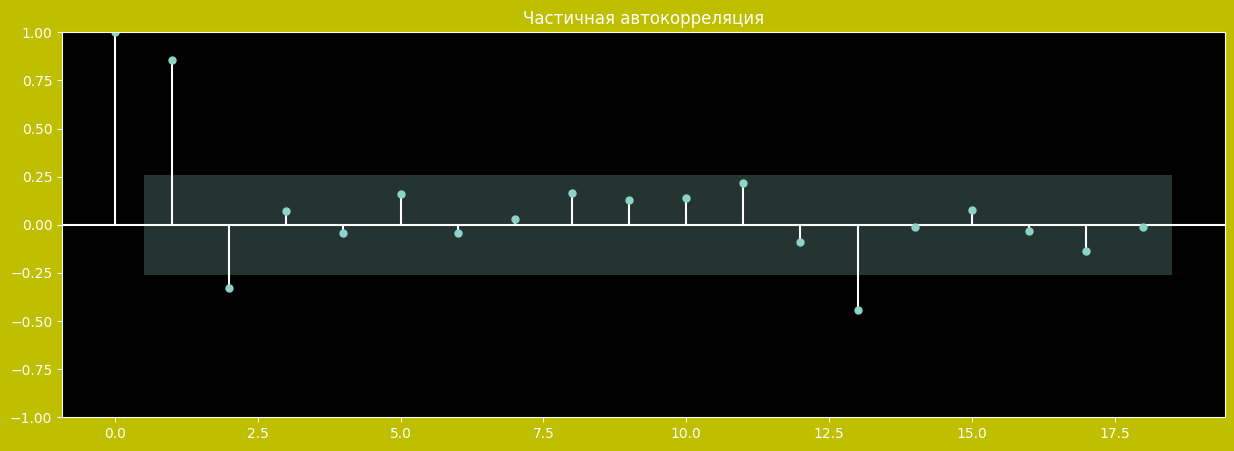

In [20]:
fig = tsaplots.plot_pacf(data_train, title='Частичная автокорреляция')
fig.set_facecolor('y')
plt.show() 

Согласно графику самые высокие показатели авторегресии при сдвигах на 1, 2, 11, 13.

In [21]:
res = []
for period in [1, 2, 11, 13]:
    model = SARIMAX(data_train, order=(period, 0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start, end)
    mae = round(mean_absolute_error(data_val, predictions), 6)
    res.append((period, mae))
best_res = min(res, key=lambda x: x[1])
print(f"period={best_res[0]}, mae={best_res[1]}")

period=13, mae=19.262446


2.3. Визуализируйте обучающую и валидационную части данных, а также прогнозные значения, полученные с помощью лучшей AR-модели.

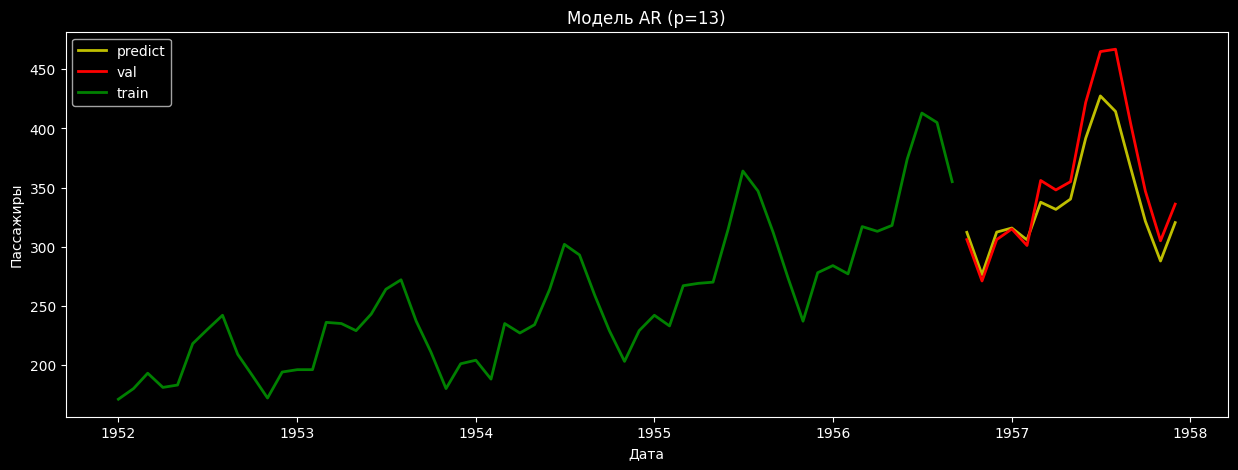

In [22]:
model = SARIMAX(data_train, order=(13, 0, 0))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start, end)
visualize_plot("Модель AR (p=13)", predictions)

3. Обучите ARMA-модель

3.1. Какие гиперпараметры отвечают именно за настройку ARMA-модели.

Параметр ошибка предыдущего наблюдения - "q"

3.2. Переберите несколько вариантов значений гиперпараметров и выберите лучший по значению метрики MAE на валидационной выборке.

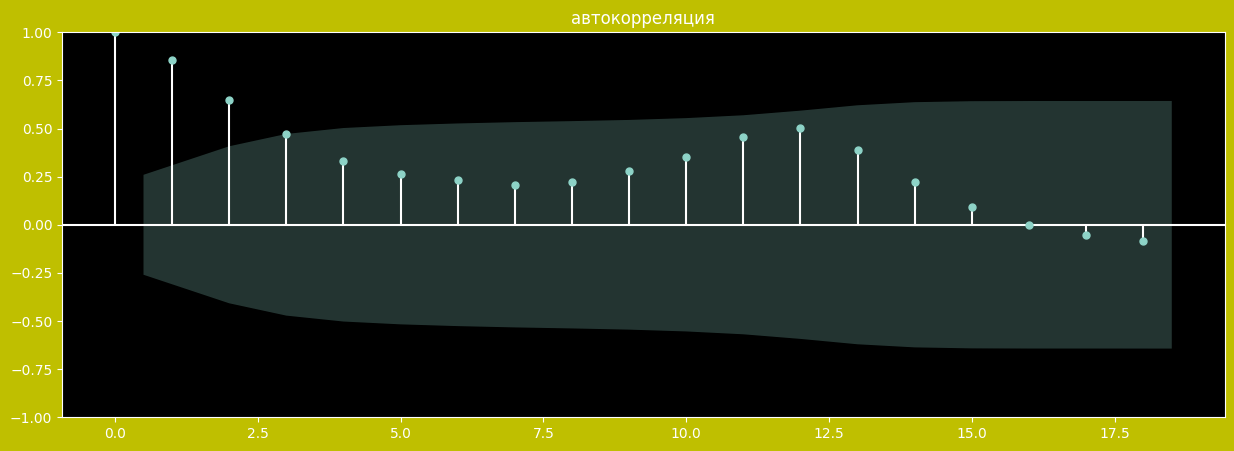

In [23]:
fig = tsaplots.plot_acf(data_train, title="автокорреляция")
fig.set_facecolor("y")
plt.show()

На графике видно, что самая высокая корреляция при сдвигах 2, 3, 4, 11, 12.

In [24]:
res = []
for q in [2, 3, 4, 11, 12]:
    model = SARIMAX(data_train, order=(13, 0, q))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start, end)
    mae = round(mean_absolute_error(data_val, predictions), 6)
    res.append((q, mae))
best_res = min(res, key=lambda x: x[1])
print(f"q={best_res[0]}, mae={best_res[1]}")

q=2, mae=18.391685


3.3. Визуализируйте обучающую и валидационную части данных, а также прогнозные значения, полученные с помощью лучшей ARMA-модели.

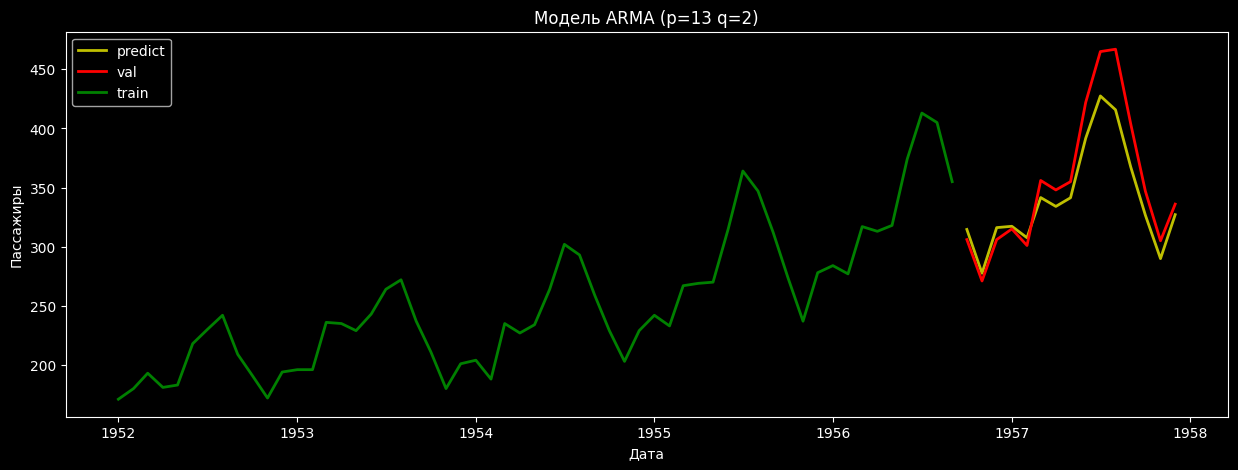

In [25]:
model = SARIMAX(data_train, order=(13, 0, 2))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start, end)
visualize_plot("Модель ARMA (p=13 q=2)", predictions)

#### 4. Обучите ARIMA-модель

3.1. Какие гиперпараметры отвечают именно за настройку ARIMA-модели.

 Параметр, отвечающий за дифференцирование - "d".

3.2. Переберите несколько вариантов значений гиперпараметров и выберите лучший по значению метрики MAE на валидационной выборке.

In [26]:
res = []
for d in [1, 2, 3]:
    model = SARIMAX(data_train, order=(13, d, 2))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start, end)
    mae = round(mean_absolute_error(data_val, predictions), 6)
    res.append((d, mae))
best_res = min(res, key=lambda x: x[1])
print(f"d={best_res[0]}, mae={best_res[1]}")

d=1, mae=12.669404


3.3. Визуализируйте обучающую и валидационную части данных, а также прогнозные значения, полученные с помощью лучшей ARIMA-модели.

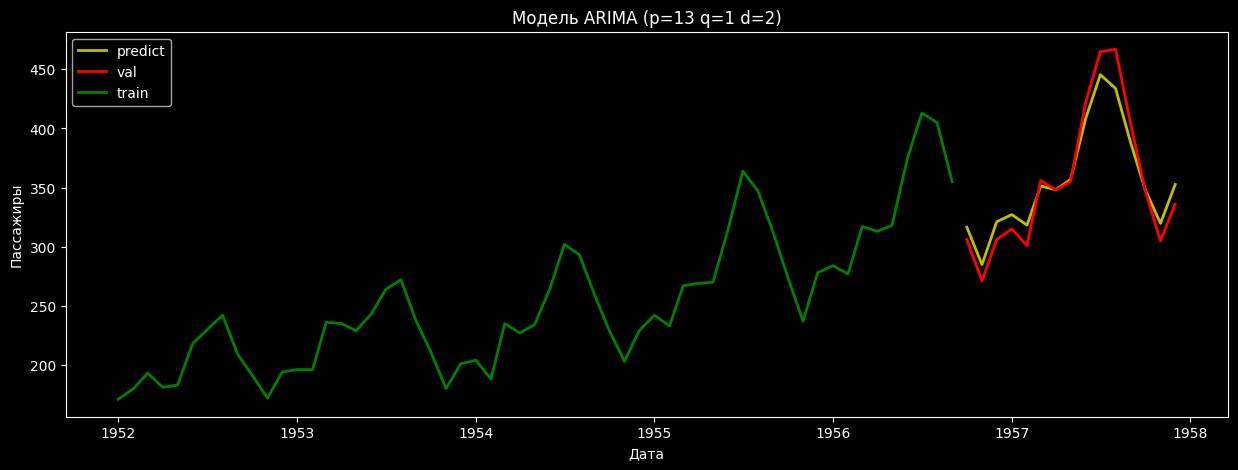

In [27]:
model = SARIMAX(data_train, order=(13, 1, 2))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start, end)
visualize_plot("Модель ARIMA (p=13 q=1 d=2)", predictions)

3.4. Сравните значение параметра, отвечающего за дифференцирование, с необходимым количеством дифференцирований для получения стационарного ряда.

In [28]:
def get_diff(data, alpha=0.05):
    p_value = 1
    counter = 0
    while p_value > alpha:
        ad_fuller_result = adfuller(data)
        p_value = ad_fuller_result[1]
        if p_value > alpha:
            data = data.diff().dropna()
            counter += 1
    return counter


print(f'Параметр дифференцирования: {get_diff(data_train)}')

Параметр дифференцирования: 2


Параметр, подобранный перебором в модели меньше, чем значение, вычисленное с помощью теста Dickey-Fuller.

#### 5. Обучите SARIMA-модель

5.1. Согласно документации определите, какие гиперпараметры необходмо указать, чтобы модель имела тип SARIMA

Добавляется параметр сезонности (P,D,Q,s),где s - это количество сезонов.

5.2. Подберите значения гиперпараметров, чтобы получить модель, не уступающую по качеству предыдущим.\
Традиционным способом поиска этих гиперпараметров является метод Бокса-Дженкинса:
- Параметр сезонности можно определить, исходя из того, какой период сезонности наблюдается на исходных данных.
- При обучении предыдущих моделей мы учитывали сезонность с помощью MA компоненты. Теперь мы будем ее учитывать в гиперпараметрах компоненты сезонности, поэтому гиперпараметр, соответствующий MA компоненте модели можно занулить.
- Дифференцирование также теперь достаточно учитывать только для компоненты сезонности.

MAE на валидационной выборке: 12.735402


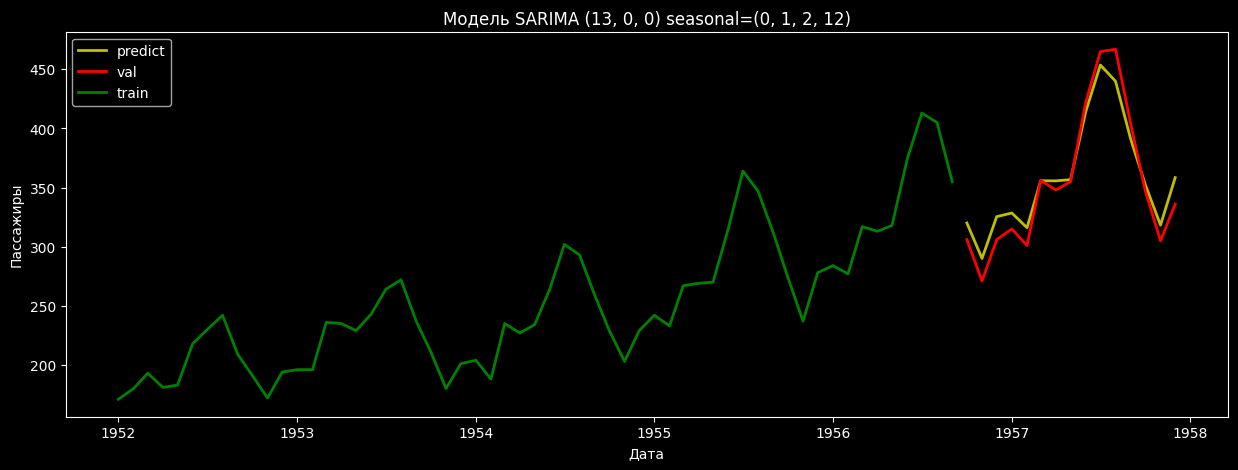

In [29]:
model = SARIMAX(data_train, order=(13, 0, 0), seasonal_order=(0, 1, 2, 12))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start, end)
print(
    f"MAE на валидационной выборке: {round(mean_absolute_error(data_val, predictions), 6)}"
)
visualize_plot("Модель SARIMA (13, 0, 0) seasonal=(0, 1, 2, 12)", predictions)

5.3.Выберите лучшую из обученных моделей и оцените ее качество на отложенной выборке

In [30]:
df_reduced = df["1958":"1960"].copy()
df_reduced.shape

(36, 1)

In [31]:
predictions = model_fit.predict("1958-01-01", "1960-12-01")

In [32]:
print(
    f"MAE на отложенной выборке: {round(mean_absolute_error(df_reduced.passengers, predictions), 6)}"
)

MAE на отложенной выборке: 28.771927


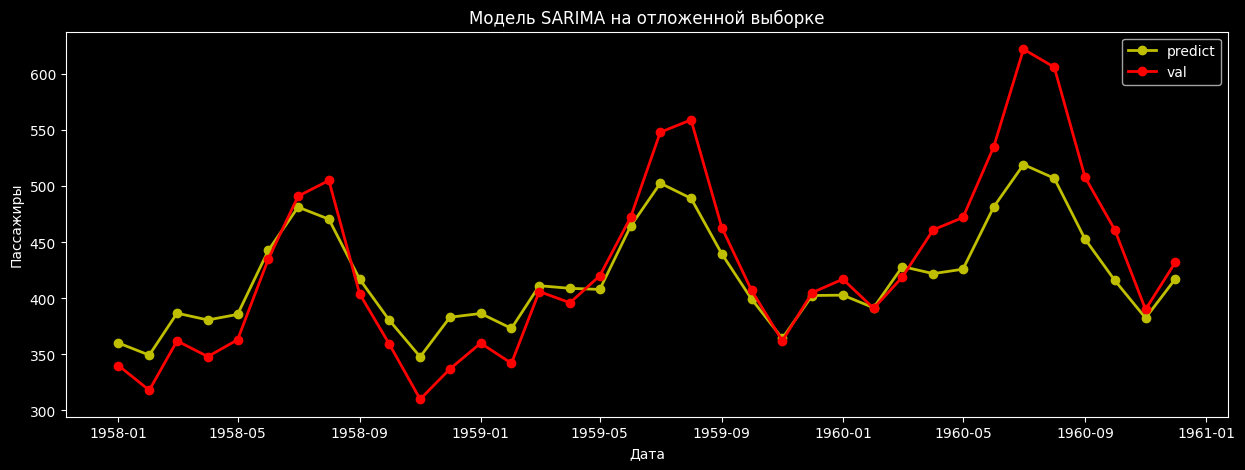

In [33]:
plt.title("Модель SARIMA на отложенной выборке")
plt.plot(predictions, label="predict", color="y", **param_plt)
plt.plot(df_reduced.passengers, label="val", color="r", **param_plt)
plt.ylabel("Пассажиры")
plt.xlabel("Дата")
plt.legend()
plt.show()

Метрика на отложенной выборке получилась 28.77, что хуже, чем при предсказании линейной регрессией.